<a href="https://colab.research.google.com/github/dan-a-iancu/Data-Analytics-and-AI/blob/master/Employee_Retention/Bias_in_AI_Risk_Predictive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fairness and Bias in AI-Based Predictive Models**



## **Introduction: Background and Data**

To appreciate how bias can arise in AI models, we will consider data for predicting whether an employee of an a large organization is likely to **voluntarily leave** the company within the next year. We are using past data that includes the following features:
  *   `time_with_company`: The employee's tenure with the company.
  *   `promotion_received`: Whether the employee received a promotion during the past two years (1 for YES, 0 for NO).
  *   `race`: The defendant's race; two values in the data, **Caucasian** or **Minority**
  *   `gender`: Two values in the data, **Male** or **Female**.
  *   `new_projects`: The total number of new projects the employee was involved with during the past two years with the company.
  *    `left_company`: Whether the employee voluntarily left the company in the subsequent one year (1 for YES, 0 for NO).

The goal here is to predict **whether the employee leaves within the subsequent year** (which is captured by `left_company` in the data) based on the other information.

In [1]:
#@markdown Install some useful packages
import os
import sys
assert sys.version_info >= (3, 5)   # Python ≥3.5 is required
import urllib.request # for file downloading

import re  # for some string formatting,, regular expressions

import numpy as np   # numpy for numerical linear algebra
import pandas as pd  # pandas for managing dataframes

#import tensorflow as tf
#from tensorflow.keras import layers

import sklearn
assert sklearn.__version__ >= "0.20"  # Scikit-Learn version ≥0.20 required
import sklearn.metrics as metrics

# adjust reporting in pandas: max 15 rows and two-digit precision
#pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

# import matplotlib and pyplot: critical packages for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install the latest version of seaborn for nicer graphics
#!pip install seaborn==0.12.2 &> /dev/null
import seaborn as sns
#assert seaborn.__version__ >= "0.12"

# install graphviz for visualizing decision trees
#!pip install graphviz  &> /dev/null
import graphviz

# import useful utilities from Google colab
from google.colab import files

# Ignore useless some warnings
import warnings
warnings.filterwarnings("ignore")

# Create a formatter function to convert values to percentages
def percentage_formatter(x, pos):
    return '{:.0%}'.format(x)

# A function to append dummies for specified variables
# returns the new dataframe and a dictionary with the categories for each categorical variable turned into a dummy
def append_dummies(data, columns):
  categories = {}  # the dictionary with categories
  data_with_dummies = data.copy() # the changed dataframe
  for col in columns:
    if col not in data.columns:
      print("WARNING. Column '{}' not among the columns in the dataframe. Skipping it.")
    elif (data[col].dtype!=int and data[col].dtype!=float):
      dummy_df = pd.get_dummies(data[col], prefix=col)
      categories[col] = list(dummy_df.columns)  # keep all the categories
      data_with_dummies = pd.merge( left=data_with_dummies, \
                                    right=dummy_df, \
                                   left_index=True, right_index=True,\
                                   how="inner", suffixes=("", "") )
  return data_with_dummies, categories

#markdown Download the data, process it following ProPublica's rules, and save it

##@markdown 1) Download data on  ProPublica GitHub account and save it as a CSV file
#url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"  # full URL to the dataset
url = "https://raw.githubusercontent.com/dan-a-iancu/Data-Analytics-and-AI/master/Employee_Retention/attrition_data.csv"
local_csv = "attrition_data.csv"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url, local_csv)    # download from website and save it locally

# Read the data into a `pandas` DataFrame
orig_full_data = pd.read_csv(local_csv, index_col="id")
data = orig_full_data.drop(columns=["decile_score","score_text"])

# print("Done with all data processing tasks!")

############################################################################
# #@markdown Define various functions to help with visualizations

# #@markdown - a function for simple visualizations of one or more features with histograms/boxplots/countplots
def visualize_features(all_data, features, figsize=(6,6), tick_fontsize=8.0, \
                       label_fontsize=9.0, num_plot='histogram', num_bins='auto', \
                       num_cols=3, custom_bins = {}):

    # calculate how many figures are needed
    num_figs = len(features)
    num_columns = (1 if num_figs==1 else num_cols)
    num_rows = int(np.ceil(num_figs/num_columns))

    # one large figure with a common title
    fig = plt.figure(figsize=(figsize[0]*num_columns,figsize[1]*num_rows))

    # title for plot
    title = ''

    for i in range(num_figs):

      # Create figure
      plt.subplot(num_rows,num_columns,i+1)
      ax1 = plt.gca()
      ax1.grid(alpha=.5, linewidth=1)
      #ax1.xaxis.label.set_size(label_fontsize)
      ax1.tick_params(axis='x',labelsize=tick_fontsize)

      ax1.yaxis.label.set_size(label_fontsize)
      ax1.tick_params(axis='y',labelsize=tick_fontsize)
      ax1.set_title(features[i], fontsize=label_fontsize)

      # numeric features with at most 5 distinct values -- treat them as categorical
      if( ((all_data[features[i]].dtype == 'float') or \
       (all_data[features[i]].dtype == 'int')) and (len(all_data[features[i]].unique()) > 5) ):
        # numeric feature with > 5 distinct values

        # plot the feature according to the option
        if( num_plot == 'histogram'):
          #title = "Histogram of {}".format(features[i])

          # set up some customized bins
          if ((len(custom_bins)>0) and (features[i] in custom_bins)):
              use_bins = custom_bins[features[i]]
          else:
              use_bins = num_bins

          sns.histplot(data = all_data[features[i]], bins=use_bins, ax=ax1)

        elif( num_plot == 'boxplot' ):
          #title = "Boxplot of {}".format(features[i])
          sns.boxplot(data = all_data[features[i]], ax=ax1)

        plt.tight_layout()
        ax1.set_xlabel('')  # no x-label; instead, we use the title

      else:
        # categorical feature
        #sns.countplot(data = all_data, x=features[i], palette="Blues", ax=ax1)
        sns.countplot(data = all_data, x=features[i], ax=ax1)
        plt.tight_layout()
        ax1.set_xlabel('')  # no x-label; instead, we use the title

    plt.tight_layout()
    # determine the title
    #tar_ylabel = '{}'.format(target_name) if target_name else 'target'
    #fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

    plt.show()

##############################################################################
# #@markdown Define some useful functions to calculate predictive performance

# #@markdown Calculate and display useful performance metrics
def calculate_metrics_classification(y_true, y_pred, y_probas_pred, \
                                     positive_label_idx=1, \
                                     label_dataset=None, display=False, \
                                     store_other=True):

      # Classification task
      labels = [None, None]
      labels[positive_label_idx] = 1.0
      labels[1-positive_label_idx] = 0.0
      conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=labels)

      # in SciKit learn, the rows are the true label, the columns are the predicted label
      TP = conf_mat[positive_label_idx][positive_label_idx]
      TN = conf_mat[1-positive_label_idx][1-positive_label_idx]
      FP = conf_mat[1-positive_label_idx][positive_label_idx]
      FN = conf_mat[positive_label_idx][1-positive_label_idx]

      TPR = TP/(TP+FN) if (TP+FN>0) else "n/d"
      TNR = TN/(TN+FP) if (TN+FP>0) else "n/d"
      FPR = 1-TNR if TPR!="n/d" else "n/d"
      FNR = 1-TPR if TNR!="n/d" else "n/d"
      accuracy = metrics.accuracy_score(y_true, y_pred)
      precision = metrics.precision_score(y_true, y_pred)
      recall = metrics.recall_score(y_true, y_pred)
      sensitivity = TPR
      specificity = TNR
      roc_auc = metrics.roc_auc_score(y_true, y_probas_pred) if len(np.unique(y_true))>1 else "n/d"

      # the names of all the performance metrics
      names = ["True Positives (TP)", "True Negatives (TN)", \
              "False Positives (FP)", "False Negatives (FN)", \
              "True Positive Rate TPR=TP/(TP+FN)", \
              "True Negative Rate TNR=TN/(TN+FP)", \
              "False Positive Rate FPR=FP/(TN+FP)=1-TNR", \
              "False Negative Rate FNR=FN/(TP+FN)=1-TPR", \
              "Accuracy =(TP+TN)/(TP+FP+TN+FN)", \
              "Area Under ROC Curve (AUC)", \
              "Precision = TP/(TP+FP)", "Recall = TPR", \
              "Sensitivity = TPR", "Specificity = TNR"]

      values = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, accuracy, roc_auc, \
                precision, recall, sensitivity, specificity  ]

      # also determine roc curve and precision_recall curve
      roc_curve = metrics.roc_curve(y_true, y_probas_pred)
      prec_recall_curve = metrics.precision_recall_curve(y_true, y_probas_pred)

      if display:
        print("Results in the {} Set:".format(label_dataset if label_dataset!=None else "Data"))
        for i in range(len(names)):
          print('{:25s} : {:.1f}'.format(names[i],values[i]))

      # compile the results into a dictionary with metrics and plots
      results = {}
      results["metrics_names"] = names
      results["metrics_values"] = values

      if store_other:
        results["others"] = {}
        results["others"]["conf_mat"] = conf_mat
        results["others"]["roc_curve"] = roc_curve
        results["others"]["prec_recall_curve"] = prec_recall_curve
      return results

#
# #@markdown A function to predict with each ML model for all samples in a dataset
def predict_all_methods_full_dataset(all_models, X_data, y_data, \
                                     dataset="Dataset", store_df=False):

      # we will store the results in a dictionary
      results = {}      # predictions/results for each sample

      # predict with each method
      for model_name in all_models.keys():
        model = all_models[model_name]["model"] # pick the model

        y_hat = model.predict(X_data)  # predict for entire training set
        pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
        y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

        # calculate summary performance
        summary = calculate_metrics_classification(y_data, y_hat, y_prob, \
                                                  pos_label_idx, \
                                                  label_dataset=dataset, display=False, \
                                                  store_other=False)

        # a dictionary with the results
        aux = {}
        aux["y_hat"] = y_hat
        aux["pos_label_idx"] = pos_label_idx
        aux["y_prob"] = y_prob
        aux["summary"] = summary

        # store the results in the models
        all_models[model_name][dataset] = aux

        # update the overall results dictionary
        results[model_name] = aux

        # store the dataframe with summary results as well, if desired
        if store_df :
          results[model_name]["summary_df"] = \
          pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                       index=summary["metrics_names"], columns=[model_name] )

      # now aggregate results for all samples into a single dataframe, including the predictions and errors
      results["all_samples_df"] = None

      for model_name in all_models.keys():
        results["all_samples_df"] = \
        pd.concat( [ results["all_samples_df"], \
                    pd.DataFrame({'{}_probability'.format(model_name) : \
                                  results[model_name]["y_prob"], \
                                  '{}_prediction'.format(model_name) : \
                                  results[model_name]["y_hat"]}, \
                                 index=X_train.index)],\
                  axis=1)

      # and similarly join the summary performance metrics into a single dataframe
      df_index = results[model_name]["summary"]["metrics_names"]
      df_col_names = []
      df_values = {}
      for model_name in all_models.keys():
        vals = results[model_name]["summary"]["metrics_values"]
        df_col_names += [model_name]
        df_values[model_name] = vals
      results["summary_df"] = pd.DataFrame( data = df_values, index=df_index, columns=df_col_names )

      return results

#
#
#
# #@markdown A function to predict with a specific ML model using different thresholds for a feature
def predict_different_thresholds(model_name, model, X_data, y_data, full_data_training, \
                                 feature,  y_thresh_dict, dataset="Dataset", \
                                 save_df=True):

    # recover all the feature values from the **original** data
    # (we do this because there may be processing for training)
    feature_values = full_data_training[feature]

    if feature_values.dtype==int or feature_values.dtype==float:
      print("Error. Predicting with different thresholds only works for categorical for now.")
      return {}

    # get the unique values of the feature
    unique_vals = feature_values.unique()

    y_hat = model.predict(X_data)  # predict for entire training set
    pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
    y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

    # figure out the values of y_predicted (potentially using different thresholds)
    if set(unique_vals).issubset(set(y_thresh_dict.keys())) :
      # all the values are proper keys
      for v in unique_vals:
        filter = (feature_values==v)
        y_hat[filter] = (y_prob[filter] >= y_thresh_dict[v])
    else:
      print("Specified keys for feature {} not sufficient".feature)
      return {}

    # we will store the results in a dictionary
    results = {}      # predictions/results for each sample

    # calculate summary performance
    summary = calculate_metrics_classification(y_true=y_data, \
                                               y_pred=y_hat, \
                                               y_probas_pred=y_prob, \
                                               positive_label_idx=pos_label_idx, \
                                               label_dataset=dataset, display=False, \
                                               store_other=False)

    # a dictionary with the results
    aux = {}
    aux["y_hat"] = y_hat
    aux["pos_label_idx"] = pos_label_idx
    aux["y_prob"] = y_prob
    aux["summary"] = summary
    aux["y_thresh_dict"] = y_thresh_dict

    # update the overall results dictionary
    results[model_name] = aux

    # store the dataframe with summary results within the model, if desired
    if save_df :
      results[model_name]["summary_df"] = \
      pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                   index=summary["metrics_names"], columns=[model_name] )

    return results

#
#
#
# #@markdown A function to visualize a binary confusion matrix
def our_plot_confusion_matrix(y_true, y_pred, class_names=None, \
                              true_on_row=True, positive_first=True, \
                              prefix_title="", figsize=(8,6), ax=None, \
                              pref_xlabel=None, pref_ylabel=None):

    # This is inspired by a similar visualization created by Google Research
    # figure out if positive label should be first or not
    num_labels = [1, 0] if positive_first else [0, 1]
    labels = ["Positives", "Negatives"] if positive_first else ["Negatives", "Positives"]
    positive_label_idx = 0 if positive_first else 1

    strings = np.asarray([['True {}'.format(labels[0]), 'False {}'.format(labels[1])], \
                          ['False {}'.format(labels[0]), 'True {}'.format(labels[1])]])

    # get the confusion matrix
    # in SciKit, ROWS = true condition, COLUMNS = predicted condition
    conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=num_labels)

    # calculate the rates
    true_conditions = conf_mat.sum(axis=1)  # sum on a row, for the true conditions in each class
    conf_mat_rates = np.array([ [conf_mat[0,0]/true_conditions[0] if true_conditions[0] > 0 else "n/d", \
                        conf_mat[0,1]/true_conditions[0] if true_conditions[0] > 0 else "n/d"], \
                       [conf_mat[1,0]/true_conditions[1] if true_conditions[1] > 0 else "n/d", \
                        conf_mat[1,1]/true_conditions[1] if true_conditions[1] > 0 else "n/d"]
                      ])

    # determine whether to switch the row/column based on the preference for displaying
    if true_on_row:
        # true condition on the row -- this is how it is now; just set up the x/y labels
        if pref_ylabel:
          ylabel = pref_ylabel
        else:
          ylabel='Ground truth'

        if pref_xlabel:
          xlabel = pref_xlabel
        else:
          xlabel='Prediction'
    else:
        # we need the true condition on the column, and the predicted on the row
        for var_ in [strings, conf_mat, conf_mat_rates]:
          var_[0,1], var_[1,0] = var_[1,0], var_[0,1]
        if pref_ylabel:
          ylabel = pref_ylabel
        else:
          ylabel='Prediction'

        if pref_xlabel:
          xlabel = pref_xlabel
        else:
          xlabel='Ground truth'

    # set up the names to use for each class when printing
    class_names = [ class_names[i] for i in num_labels ] if class_names!=None else\
    [str(i) for i in num_labels]

    df_cm = pd.DataFrame(
        conf_mat, index=class_names, columns=class_names,
    )

    #sns.set_context("notebook", font_scale=1.25)
    ax = ax or plt.gca()
    #ax.set_title(prefix_title + 'Confusion Matrix ')
    ax.set_title(prefix_title)

    # Combine the numerical value with its description
    labels = (np.asarray(
        ["{0:g}\n{1}\n(Rate: {2:.1f}%)".format(value, string, rate*100) \
         for value, string, rate in zip(
             conf_mat.flatten(), strings.flatten(), conf_mat_rates.flatten())\
         ])).reshape(2, 2)

    heatmap = sns.heatmap(conf_mat_rates, annot=labels, fmt="",
        linewidths=2.0, cmap=sns.color_palette("Blues"), ax=ax, \
        annot_kws={"fontsize":12}, xticklabels=class_names, \
        yticklabels=class_names);
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    return 0

#
#
#
# #@markdown Function to evaluate predictive performance depending on a feature
def evaluate_performance_with_feature_values(model_name, model, feature, X_data, \
                                             y_data, full_data_training, \
                                             results_full_data,\
                                             num_bins=3, \
                                             prefix_title="", class_names=None,\
                                             include_full_dataset_eval=True,\
                                             include_separate_feature_eval=True,\
                                             display_conf_mat=True,\
                                             display_roc_pr=True, plot_together=False,\
                                             ax_confmat=None, ax_roc=None, \
                                             ax_pr=None, figsize=(7,7),\
                                             pref_xlabel=None, pref_ylabel=None):

  # check the behavior of flags
  if (include_full_dataset_eval==False) and (include_separate_feature_eval==False):
      # silly behavior: if none of the flags are set, we set both to true
      include_full_dataset_eval = True
      include_separate_feature_eval = True

  # select the right model to use and the right column to use for summary results
  y_hat = results_full_data["y_hat"]
  y_prob = results_full_data["y_prob"]
  pos_index = results_full_data["pos_label_idx"]

  # recover all the feature values from the **original** data
  # (we do this because there may be processing for training)
  feature_values = full_data_training[feature]

  if feature_values.dtype==int or feature_values.dtype==float:
    # if numeric feature - handle separately by discretizing
    # print("{} is a numeric feature. Will discretize into {} bins.".format(feature,num_bins))
    feature_values, bins =  pd.cut(feature_values, bins=num_bins, retbins=True,\
                                   include_lowest=True, ordered=True)

  # get the unique values of the feature
  unique_vals = feature_values.unique()

  # a few plotting settings
  fontsize = 12  # font size for titles in plots

  if display_conf_mat :
    # display the confusion matrices

    # determine how many plots are needed
    num_figs = (1 if include_full_dataset_eval else 0)  + \
      len(unique_vals)*(1 if include_separate_feature_eval else 0)

    if ax_confmat == None:
        # create a figure of the desired size
        fig_cm = plt.figure(figsize=(figsize[0]*num_figs,figsize[1]))
        # get all the axes for subplots
        axs_cm = fig_cm.subplots(1, num_figs)
    else:
        # use the given axis
        axs_cm = ax_confmat

    # plot the confusion matrix for entire data
    if include_full_dataset_eval:
        # handle axes properly; if it's a single figure, then it's not subscriptable!
        if num_figs == 1:
            ax1=axs_cm
        else:
            ax1=axs_cm[0]
        aux = our_plot_confusion_matrix(y_true=y_data, y_pred=y_hat,\
                                        class_names=class_names, \
                                        true_on_row=True, positive_first=True, \
                                        prefix_title="", \
                                        figsize=(fig_width,fig_height), ax=ax1,\
                                        pref_xlabel=pref_xlabel, \
                                        pref_ylabel=pref_ylabel)
        ax1.set_title(prefix_title + "All Employees",\
                            fontsize=fontsize)

  if display_roc_pr:
    # if we want to display the ROC / prec-recall curves
    # WARNING!!! THIS CODE HAS NOT BEEN TESTED IN A WHILE! IF USING, CHECK!!

    # cmap = mpl.cm.get_cmap("Blues")
    cmap = mpl.cm.get_cmap("jet")

    if (plot_together==False) or (ax_roc==None) or (ax_pr==None):
        # cannot plot together
        plot_together = False
        roc_pr_fig = plt.figure(figsize=(figsize[0]*2,figsize[1]))  # create a figure of the desired size

        ax_roc, ax_pr = roc_pr_fig.subplots(1,2)

        # settings for the ROC curve
        # set the colors into different shades of blue
        ax_roc.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])

        # settings for the precision-recall curve
        # set the colors into different shades of blue
        ax_pr.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])

        # will not use any prefix for the labels in the legend
        label_prefix = ""
        linestyle = "-"
    else:
        # we will be plotting the ROC/prec-recall on top of existing plots
        label_prefix = prefix_title   # use prefix in the legend
        prefix_title = ""     # no prefix in the title
        linestyle = "--"

    metrics.plot_roc_curve(model, X_data, y_data, \
                           sample_weight=None, response_method='auto', \
                           name='{}All Employees'.format(label_prefix), ax=ax_roc,\
                           linestyle=linestyle)
    ax_roc.set_title("{}Comparison of ROC Curves for '{}'".format(prefix_title,feature),\
                     fontsize=fontsize)

    # plot precision-recall curve with full dataset
    metrics.plot_precision_recall_curve(model, X_data, y_data, \
                                        sample_weight=None, response_method='auto', \
                                        name='{}All Employees'.format(label_prefix), ax=ax_pr, \
                                        linestyle=linestyle)
    ax_pr.set_title("{}Comparison of Precision-Recall Curves for '{}'".\
                    format(prefix_title,feature),fontsize=fontsize)
  else:
    ax_roc = None
    ax_pr = None

  # go through each individual value for the feature and calculate metrics + do plots
  if include_separate_feature_eval:
      for i in range(len(unique_vals)):
        v = unique_vals[i]
        filter = (feature_values==v)  # filter for all samples with value v
        if (len(y_data[filter])):
          results_v = calculate_metrics_classification(y_true=y_data[filter], \
                                                      y_pred=y_hat[filter], \
                                                      y_probas_pred=y_prob[filter], \
                                                      positive_label_idx=pos_index, \
                                                      display=False)

          # copy the column with aggregate results on the entire dataset
          col_v_name = "{}={}".format(feature,v)

          # if needed, visualize the confusion matrix
          if display_conf_mat:
              plot_idx = (1 if include_full_dataset_eval else 0) + i

              # plot the confusion matrix with the correct feature
              aux = our_plot_confusion_matrix(y_true=y_data[filter], \
                                              y_pred=y_hat[filter],\
                                              class_names=class_names, \
                                              true_on_row=True, positive_first=True, \
                                              prefix_title="", \
                                              figsize=(fig_width,fig_height), \
                                              ax=axs_cm[plot_idx], pref_xlabel=pref_xlabel,\
                                              pref_ylabel=pref_ylabel)
              axs_cm[plot_idx].set_title(prefix_title + col_v_name,fontsize=fontsize)

          if display_roc_pr:
            # plot ROC curve with partial data
            label = "{}{}".format(label_prefix,col_v_name)
            metrics.plot_roc_curve(model, X_data[filter], y_data[filter], \
                                  sample_weight=None, response_method='auto', \
                                  name=label, ax=ax_roc,  linestyle=linestyle)

            # plot precision-recall curve with partial data
            metrics.plot_precision_recall_curve(model, X_data[filter], y_data[filter], \
                                                sample_weight=None, response_method='auto', \
                                                name=label, ax=ax_pr, linestyle=linestyle)
        else:
          print('Feature {} has no values equal to {}. Will omit that category.'.format(feature,v))

  return ;

_________________
# **1. Understand the Data**
*Explore the data using some of the visualizations below. We suggest expanding the hidden cells as needed to see the output.*

<font color=blue><br>
**Q1: Based on the visualizations below, how would you characterize:**<br>
 - **the relationship between turnover (`left_company`) and other features?** _(please answer in the poll)_<br>
 - **the relationship between race (`race`) and other features?** _(brainstorm)_</font>

## Visualize each data field

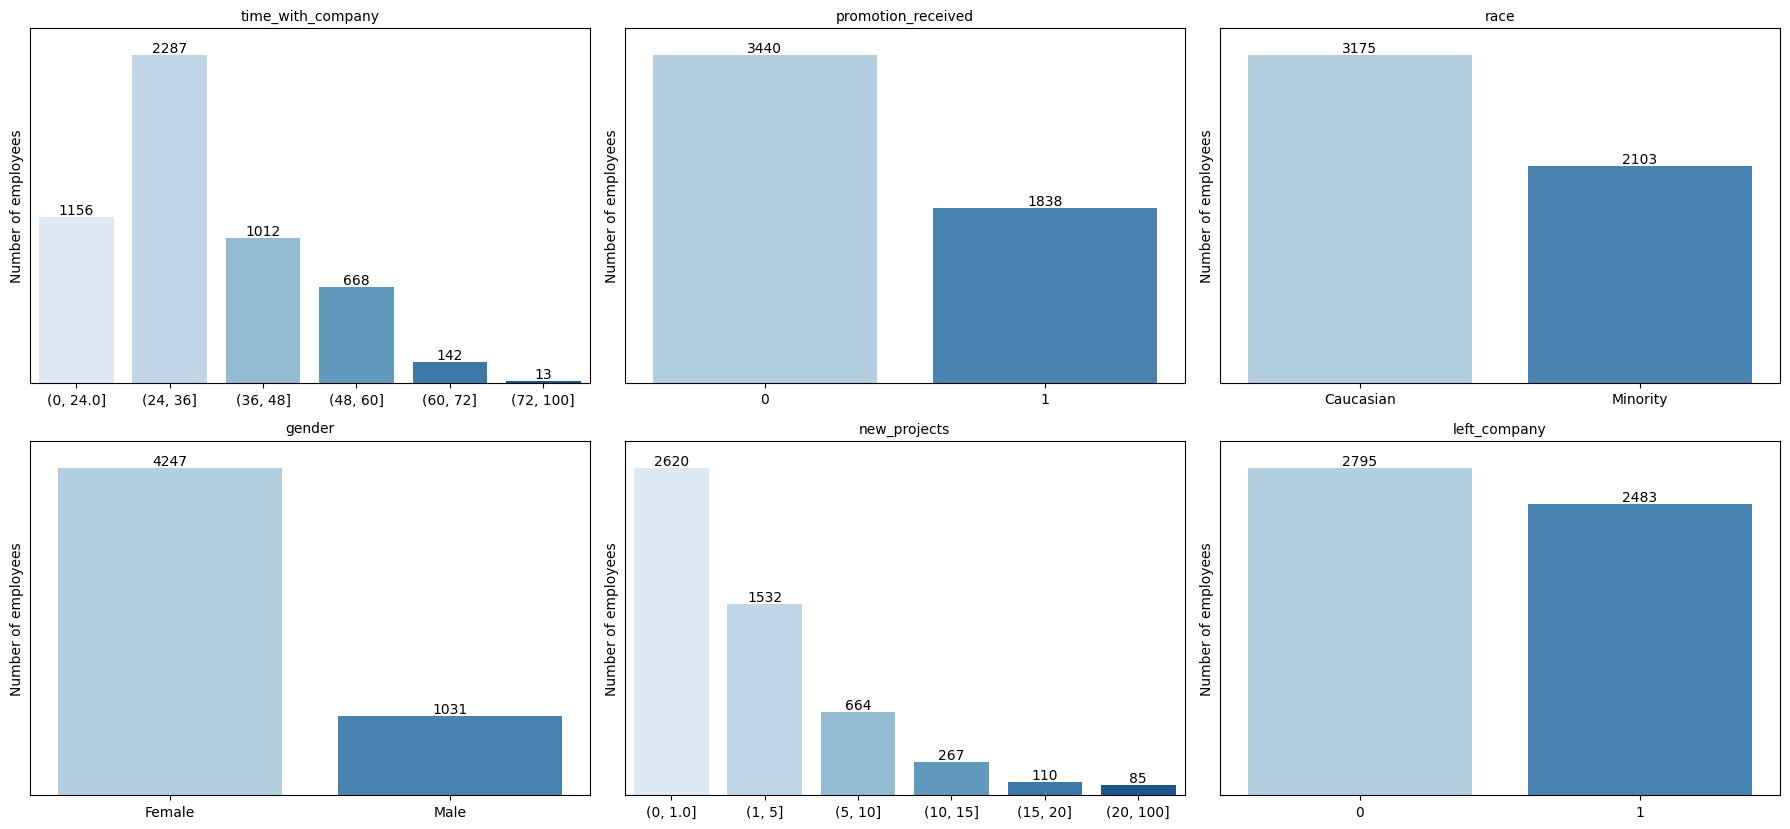

In [2]:
# append dummies and store categories for all data (useful for plotting routines)
data_with_dummies, data_categories = append_dummies(data, data.columns)

all_features = ['time_with_company', 'promotion_received', 'race', 'gender', \
                'new_projects', 'left_company']

#@markdown **Build separate visualizations**

#@markdown Select which features to visualize (**"All"** will plot all the features):
feature = "All" #@param ['All', 'time_with_company', 'promotion_received', 'race', 'gender', 'new_projects', 'left_company']

# list of all features -- does NOT include the risk score (decide & text)
if(feature=="All"):
  which_features = all_features
else:
  which_features = [feature]

#@markdown Feel free to adjust the figure size and the font size
figures_per_row = 3
figure_width = '6.0' #@param ['5.0', '6.0', '7.0', '8.0']
figure_width=float(figure_width)
figure_height = 0.7*figure_width

font_size = '10.0' #@param ['8.0', '9.0', '10.0', '11.0', '12.0']
font_size = float(font_size)
font_size_ticks = 10

## GOOD SETTINGS FOR POWERPOINT
# font_size = 16.0
# font_size_ticks = 13

# #@markdown For an average dependency plot:
# #@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
# discretization_type = "uniform"
#discretization_type = "quantile"
num_bins = 10
num_quantiles=5
discretization_type = "custom"
custom_bins = {"time_with_company": [0,24,36,48,60,72,100], \
               "new_projects": [0,1,5,10,15,20,100]}

# #@markdown Select whether to also display counts<br>
# #@markdown *Clarification: When displaying counts, the line will show the turnover rate (left axis) and the bars will show the counts (right axis)*
# display_counts = True #@param {type:"boolean"}

if feature=="All":
  which_features = all_features
else:
  which_features = [feature]

# calculate how many figures are needed
num_figs = len(which_features)
num_columns = (1 if num_figs==1 else figures_per_row)
num_rows = int(np.ceil(num_figs/num_columns))

# one large figure with a common title
fig = plt.figure(figsize=(figure_width*num_columns,figure_height*num_rows))

# title for plot
title = ''

for i in range(num_figs):

  ### CREATE THE DATA
  feature=which_features[i]
  if feature in data_categories:
      # categorical feature -> no discretization
      binned_column = feature
      xlabels = data_with_dummies[feature].unique()
      sorted_labels = data_with_dummies[binned_column].unique()

  elif len(data[feature].unique()) <= 15:
      # numeric feature with at most 15 unique values
      binned_column = feature
      xlabels = data_with_dummies[feature].unique()
      sorted_labels = data_with_dummies[binned_column].unique()

  else:
      # this is a numeric feature with more than 15 unique values
      binned_column = 'feature_bins'  # a different name for the discretized col

      if discretization_type == "custom":
          # custom discretization
          if feature in custom_bins:
              bins_to_use = custom_bins[feature]
          else:
              print("Unrecognized feature. Defaulting to auto number of bins.")
              bins_to_use = num_bins

          # use the custom discretization
          out, bins = pd.cut(data_with_dummies[feature], bins=bins_to_use, \
                            precision=0, retbins=True, include_lowest=True)

      elif discretization_type == "quantile":
          out, bins = pd.qcut(data_with_dummies[feature], q=num_quantiles, \
                              precision=0, retbins=True)
      elif discretization_type == "uniform":
          out, bins = pd.cut(data_with_dummies[feature], bins=num_bins, \
                            precision=0, retbins=True)

      # convert all the values of the categories to strings
      out = out.astype(str)

      # write to dataframe
      data_with_dummies[binned_column] = out

      ## NEXT BIT IS ANNOYING, BUT IMPORTANT:
      # make sure the labels (ie, intervals) appear sorted in increasing order
      # and make sure that the left side of the first interval is 0 if the variable is non-negative

      # unique elements
      all_labels = data_with_dummies[binned_column].unique()
      #all_labels = list(set(out))

      # extract all the left points and format the first one if needed
      start_interval = np.zeros(len(all_labels))
      min_value_feature = data_with_dummies[feature].min()  # smallest value of the feature
      for j in range(len(all_labels)):
            label = all_labels[j]
            pattern = r"\((-?\d+(?:\.\d+)?),\s*(-?\d+(?:\.\d+)?)\]"
            match = re.search(pattern, label)
            value1, value2 = match.groups()
            value1 = float(value1)

            # if feature is taking positive values -> the left side should be >=0
            # (this only applies to the very first interval...)
            if (min_value_feature >= 0) and ( value1 <= 0):
                value1 = 0
                all_labels[j] = f"(0, {float(value2)}]"
                data_with_dummies[binned_column][data_with_dummies[binned_column]==label] = all_labels[j]

            start_interval[j] = float(value1)

      # now sort the labels according to the left side of the interval
      sorted_labels = [all_labels[j] for j in np.argsort(start_interval)]

  # group the dataframe based on the desired feature
  grouped_df = data_with_dummies.groupby(binned_column).agg({feature: 'count'})
  # grouped_df.set_index(binned_column, inplace=True)

  grouped_df = grouped_df.loc[sorted_labels]
  grouped_df.rename(columns={feature: 'count'}, inplace=True)
  #grouped_df["text_rr"] = grouped_df['recid_rate'].apply(lambda x: '{:.2%}'.format(x))
  #grouped_df[binned_column] = grouped_df[binned_column].astype(str)

  ### Create the figure ###
  plt.subplot(num_rows,num_columns,i+1)
  ax1 = plt.gca()
  ax1.grid(alpha=.5, linewidth=2)
  ax1.xaxis.label.set_size(font_size)
  ax1.yaxis.label.set_size(font_size)
  ax1.tick_params(axis='x',labelsize=font_size_ticks)
  ax1.tick_params(axis='y',labelsize=font_size_ticks)

  sns.barplot(x=grouped_df.index, y='count', data=grouped_df, \
              alpha=1.0, ax=ax1, zorder=1, palette="Blues")

  # add labels on top of the bars; because this is a barplot, one container per bar
  for cont in ax1.containers:
    ax1.bar_label(cont, label_type='edge', fontsize=font_size_ticks)

  # for xi in grouped_df.index:
  #   yi = grouped_df.loc[xi,'count']
  #   ax1.text(xi, yi+0.02, '{:d}'.format(yi), ha='center', va='bottom', \
  #            fontsize=font_size_ticks, zorder=3)

  # rotate labels if more than 3 values on x axis
  # if len(grouped_df) > 3:
  #     plt.xticks(rotation=45, ha='right')
  #plt.xlabel(feature)
  plt.title(feature, fontsize=font_size)
  plt.xlabel("")
  ax1.set_ylabel('Number of employees', fontsize=font_size)

  bottom, top = ax1.get_ylim()
  ax1.set_ylim(bottom, top=top*1.03)

  ax1.set_yticks([])  # remove the y-ticks altogether

plt.tight_layout()
# determine the title
#tar_ylabel = '{}'.format(target_name) if target_name else 'target'
#fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

plt.show()

## Examine relationship between turnover (**left_company**) and other data

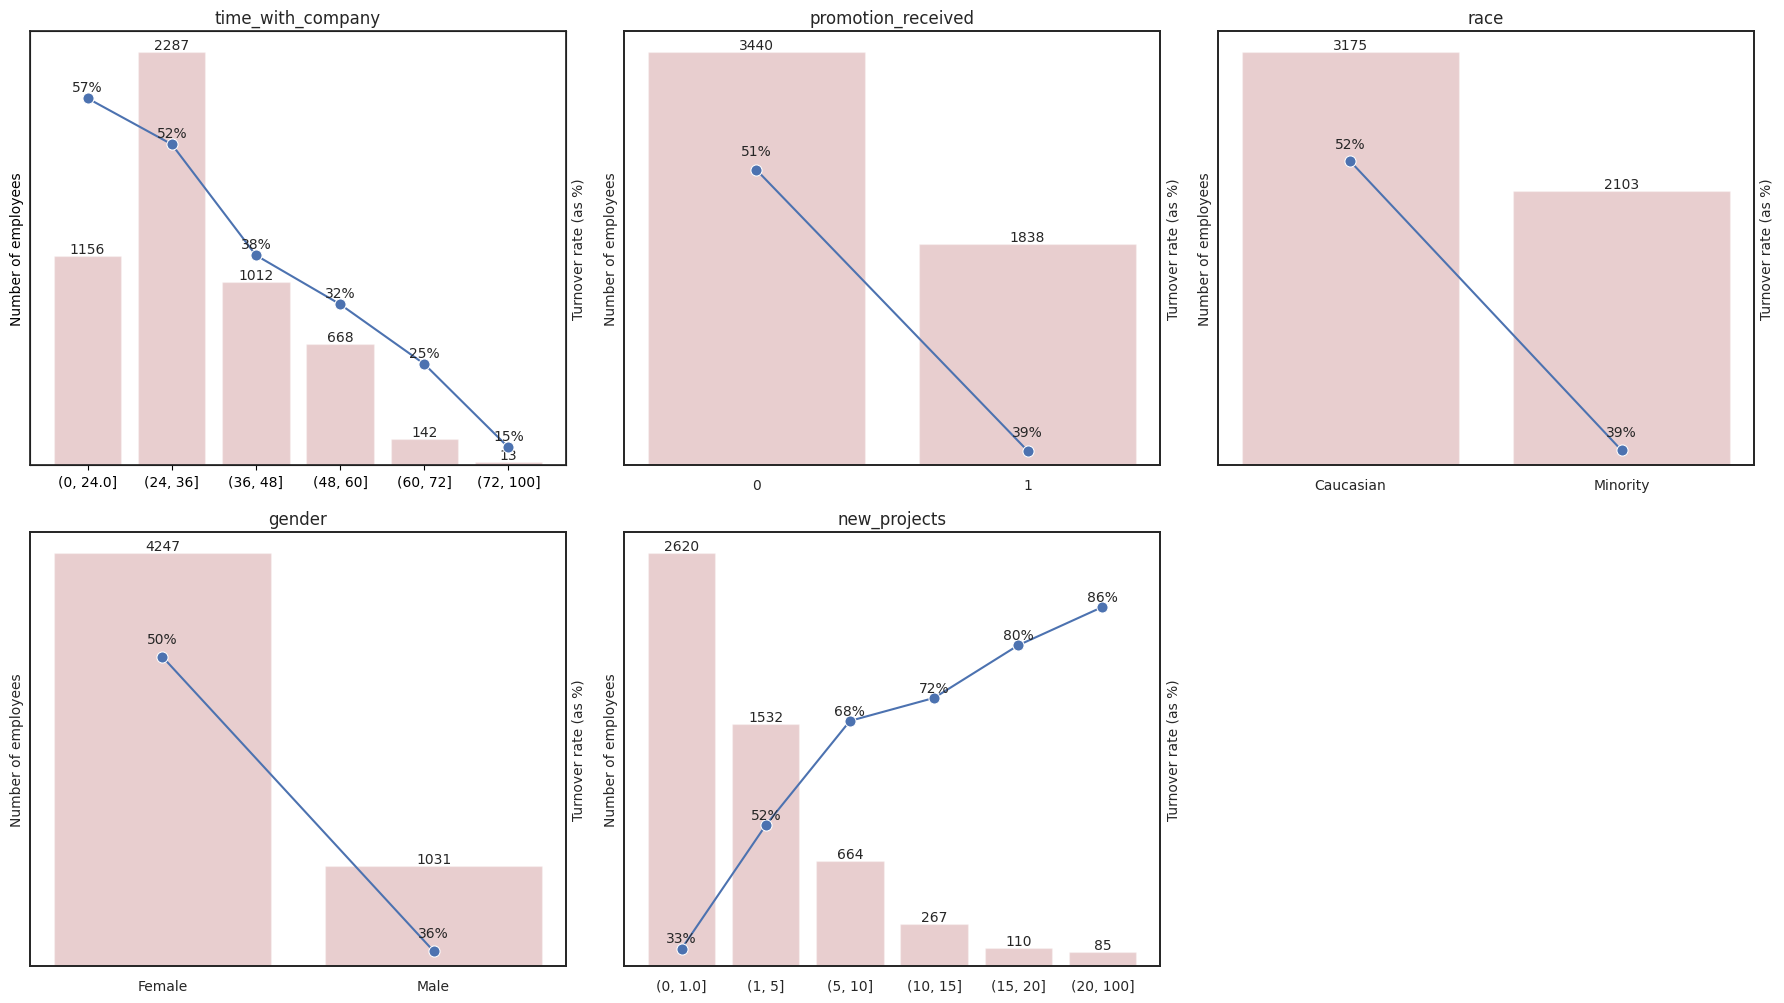

In [3]:
# append dummies and store categories for all data (useful for plotting routines)
all_features = ['time_with_company', 'promotion_received', 'race', 'gender', \
                'new_projects']

target_name = 'left_company'

#@markdown Select one of the data fields (selecting **All** will display all dependencies):
feature = 'All' #@param ['All', 'time_with_company', 'promotion_received', 'race', 'gender',  'new_projects']

#@markdown Feel free to adjust the figure size and the font size
figures_per_row = 3
figure_width = '6.0' #@param ['5.0', '6.0', '7.0', '8.0']
figure_width=float(figure_width)
figure_height = 0.85*figure_width

font_size = '10.0' #@param ['8.0', '9.0', '10.0', '11.0', '12.0']
font_size = float(font_size)
font_size_ticks = 10

## GOOD SETTINGS FOR POWERPOINT
# font_size = 16.0
# font_size_ticks = 13
# figure_height = 0.85*figure_width

# #@markdown For an average dependency plot:
# #@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
#discretization_type = "uniform"
#discretization_type = "quantile"
discretization_type = "custom"
num_bins = 10
num_quantiles=5

# #@markdown Select whether to also display counts<br>
# #@markdown *Clarification: When displaying counts, the line will show the attrition rate (left axis) and the bars will show the counts (right axis)*
# display_counts = False #@param {type:"boolean"}

display_ylabels = True

if feature=="All":
  which_features = all_features
else:
  which_features = [feature]

# calculate how many figures are needed
num_figs = len(which_features)
num_columns = (1 if num_figs==1 else figures_per_row)
num_rows = int(np.ceil(num_figs/num_columns))

# one large figure with a common title
fig = plt.figure(figsize=(figure_width*num_columns,figure_height*num_rows))

# title for plot
title = ''

for i in range(num_figs):

  ### CREATE THE DATA
  feature=which_features[i]
  if feature in data_categories:
      # categorical feature -> no discretization
      binned_column = feature
      xlabels = data_with_dummies[feature].unique()
      sorted_labels = data_with_dummies[binned_column].unique()

  elif len(data[feature].unique()) <= 15:
      # numeric feature with at most 15 unique values
      binned_column = feature
      xlabels = data_with_dummies[feature].unique()
      sorted_labels = data_with_dummies[binned_column].unique()

  else:
      # this is a numeric feature with more than 15 unique values
      binned_column = 'feature_bins'  # a different name for the discretized col

      if discretization_type == "custom":
          # custom discretization
          if feature in custom_bins:
              bins_to_use = custom_bins[feature]
          else:
              print("Unrecognized feature. Defaulting to auto number of bins.")
              bins_to_use = num_bins

          # use the custom discretization
          out, bins = pd.cut(data_with_dummies[feature], bins=bins_to_use, \
                            precision=0, retbins=True, include_lowest=True)

      elif discretization_type == "quantile":
          out, bins = pd.qcut(data_with_dummies[feature], q=num_quantiles, \
                              precision=0, retbins=True)
      elif discretization_type == "uniform":
          out, bins = pd.cut(data_with_dummies[feature], bins=num_bins, \
                            precision=0, retbins=True)

      # convert all the values of the categories to strings
      out = out.astype(str)

      # write to dataframe
      data_with_dummies[binned_column] = out

      ## NEXT BIT IS ANNOYING, BUT IMPORTANT:
      # make sure the labels (ie, intervals) appear sorted in increasing order
      # and make sure that the left side of the first interval is 0 if the variable is non-negative

      # unique elements
      all_labels = data_with_dummies[binned_column].unique()
      #all_labels = list(set(out))

      # extract all the left points and format the first one if needed
      start_interval = np.zeros(len(all_labels))
      min_value_feature = data_with_dummies[feature].min()  # smallest value of the feature
      for j in range(len(all_labels)):
            label = all_labels[j]
            pattern = r"\((-?\d+(?:\.\d+)?),\s*(-?\d+(?:\.\d+)?)\]"
            match = re.search(pattern, label)
            value1, value2 = match.groups()
            value1 = float(value1)

            # if feature is taking positive values -> the left side should be >=0
            # (this only applies to the very first interval...)
            if (min_value_feature >= 0) and ( value1 <= 0):
                value1 = 0
                all_labels[j] = f"(0, {float(value2)}]"
                data_with_dummies[binned_column][data_with_dummies[binned_column]==label] = all_labels[j]

            start_interval[j] = float(value1)

      # now sort the labels according to the left side of the interval
      sorted_labels = [all_labels[j] for j in np.argsort(start_interval)]

  # group the dataframe based on the desired feature
  grouped_df = data_with_dummies.groupby(binned_column).agg({feature: 'count', \
                                                             target_name: 'mean'})
  # grouped_df.set_index(binned_column, inplace=True)
  grouped_df = grouped_df.loc[sorted_labels]
  grouped_df.rename(columns={feature: 'count', target_name: target_name}, inplace=True)
  #grouped_df["text_rr"] = grouped_df['recid_rate'].apply(lambda x: '{:.2%}'.format(x))
  #grouped_df[binned_column] = grouped_df[binned_column].astype(str)

  ### Create the figure ###
  plt.subplot(num_rows,num_columns,i+1)
  sns.set_theme(style="white")
  ax1 = plt.gca()
  ax1.grid(alpha=1.0, linewidth=2)
  ax1.xaxis.label.set_size(font_size)
  ax1.tick_params(axis='x',labelsize=font_size_ticks)

  # first y-axis shows barplot with number of points
  sns.barplot(x=grouped_df.index, y='count', data=grouped_df, color='r', \
              alpha=0.3, ax=ax1, zorder=1)
  ax1.tick_params(axis='y',labelsize=font_size_ticks)
  ax1.yaxis.label.set_size(font_size)
  ax1.set_xlabel("")
  if display_ylabels:
      ax1.set_ylabel('Number of employees')
  else:
      ax1.set_ylabel('')

  # add labels on top of the bars
  ax1.bar_label(ax1.containers[0], label_type='edge', fontsize=font_size_ticks)

  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

  # secondary y-axis for line plot for attrition rate (ie, the average of left_company)
  ax2 = plt.twinx()
  sns.lineplot(x=grouped_df.index, y=target_name, marker='o', \
               markersize=8, linewidth=1.5, data=grouped_df, axes=ax2, \
               sort=True, zorder= 3)

  if display_ylabels:
      ax2.set_ylabel('Turnover rate (as %)', fontsize=font_size)
  else:
      ax2.set_ylabel('')

  # for tick_label in ax2.get_yticklabels():
  #   tick_label.set_color('blue')

  # express recidivism rate as percentage
  ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(percentage_formatter))
  plt.title(feature)
  plt.xlabel("")

  # rotate labels if more than 3 values on x axis
  # if len(grouped_df) > 3:
  #     plt.xticks(rotation=45, ha='right')

  # plot the values on top as well
  eps=0.005
  for xi in grouped_df.index:
    yattr = grouped_df.loc[xi,target_name]
    #ycount = grouped_df.loc[xi,"count"]
    #ax1.text(xi, ycount+eps, '{:d}'.format(ycount), ha='center', va='bottom', \
    #          fontsize=font_size_ticks, zorder=3)
    ax2.text(xi, yattr+eps, f'{yattr:.0%}', ha='center', va='bottom', \
             fontsize=font_size_ticks, zorder=3)

  bottom, top = ax2.get_ylim()
  ax2.set_ylim(bottom, top=top*1.10)
  ax2.tick_params(axis='y',labelsize=font_size_ticks)

  # uncomment the follow two lines to hide the y-ticks altogether
  ax1.set_yticks([])  # remove the y-ticks altogether
  ax2.set_yticks([])  # remove the y-ticks altogether
  ax1.grid(False)
  ax2.grid(False)

plt.tight_layout()
# determine the title
#tar_ylabel = '{}'.format(target_name) if target_name else 'target'
#fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

plt.show()

**A clarification about each plot:**
- The **pink bars** show the number of employees in each category (the value on top of each bar).
- The <font color=blue>**blue line plot**</font> shows the turnover rate, calculated as the fraction of employees in that category who left the company within a year.

**Example:** _in the plot corresponding to `time_with_company`, among the 1,156 employees with tenure of at most 24 months, the attrition rate was 57%._


## Examine relationship between **race** and other data

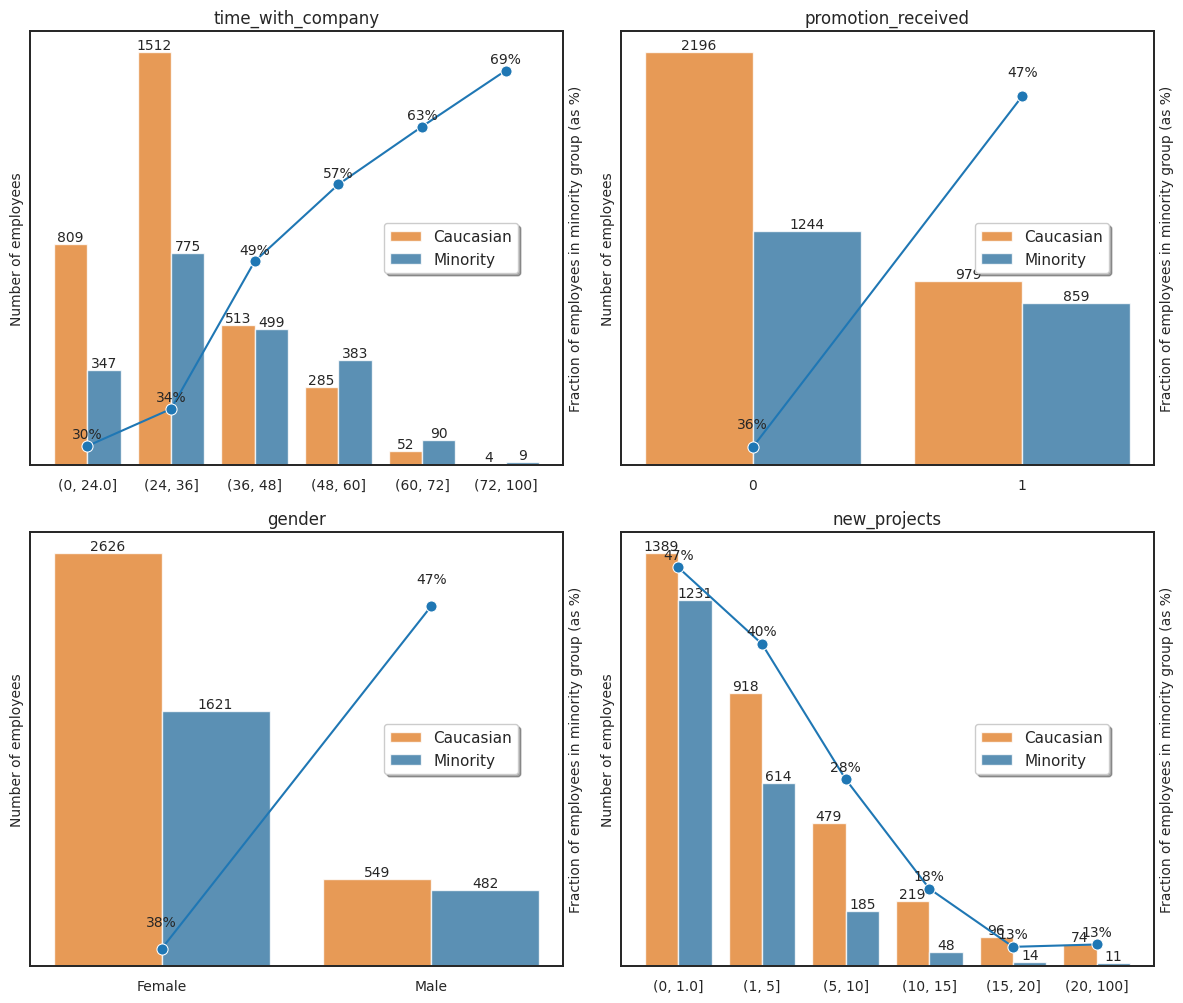

In [4]:
all_features = ['time_with_company', 'promotion_received', 'gender', \
                'new_projects']

# to make this easy, we also display the fraction of minority employees
target_name = 'race_Minority'

#@markdown Select one of the data fields (selecting **All** will display all dependencies):
feature = 'All' #@param ['All', 'time_with_company', 'promotion_received', 'gender', 'new_projects']


#@markdown Feel free to adjust the figure size and the font size
figures_per_row = 2
figure_width = '6.0' #@param ['5.0', '6.0', '7.0', '8.0']
figure_width=float(figure_width)
figure_height = 0.85*figure_width

font_size = '10.0' #@param ['8.0', '9.0', '10.0', '11.0', '12.0']
font_size = float(font_size)
font_size_ticks = 10

## GOOD SETTINGS FOR POWERPOINT
# font_size = 16.0
# font_size_ticks = 13

# #@markdown For an average dependency plot:
# #@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
#discretization_type = "uniform"
#discretization_type = "quantile"
num_bins = 10
num_quantiles=5
discretization_type = "custom"
max_unique_vals_numeric=10  # number of unique vals above which to discretize a numeric feature

# #@markdown Select whether to also display counts<br>
# #@markdown *Clarification: When displaying counts, the line will show the fraction of **Minority** employees (left axis) and the bars will show the counts (right axis)*
# display_counts = True #@param {type:"boolean"}

if feature=="All":
  which_features = all_features
else:
  which_features = [feature]

# calculate how many figures are needed
num_figs = len(which_features)
num_columns = (1 if num_figs==1 else figures_per_row)
num_rows = int(np.ceil(num_figs/num_columns))

# one large figure with a common title
fig = plt.figure(figsize=(figure_width*num_columns,figure_height*num_rows))

palette_choice = 'tab10'
palette = sns.color_palette(palette_choice)

# title for plot
title = ''

for i in range(num_figs):

  ### CREATE THE DATA
  feature=which_features[i]
  if feature in data_categories:
      # categorical feature -> no discretization
      binned_column = feature
      xlabels = data_with_dummies[feature].unique()
      sorted_labels = data_with_dummies[binned_column].unique()

  elif len(data[feature].unique()) <= max_unique_vals_numeric:
      # numeric feature with few unique values
      binned_column = feature
      xlabels = data_with_dummies[feature].unique()
      sorted_labels = data_with_dummies[binned_column].unique()

  else:
      # this is a numeric feature with more than 15 unique values
      binned_column = 'feature_bins'  # a different name for the discretized col

      if discretization_type == "custom":
          # custom discretization
          if feature in custom_bins:
              bins_to_use = custom_bins[feature]
          else:
              print("Unrecognized feature. Defaulting to auto number of bins.")
              bins_to_use = num_bins

          # use the custom discretization
          out, bins = pd.cut(data_with_dummies[feature], bins=bins_to_use, \
                            precision=0, retbins=True, include_lowest=True)

      elif discretization_type == "quantile":
          out, bins = pd.qcut(data_with_dummies[feature], q=num_quantiles, \
                              precision=0, retbins=True)
      elif discretization_type == "uniform":
          out, bins = pd.cut(data_with_dummies[feature], bins=num_bins, \
                            precision=0, retbins=True)

      # convert all the values of the categories to strings
      out = out.astype(str)

      # write to dataframe
      data_with_dummies[binned_column] = out

      ## NEXT BIT IS ANNOYING, BUT IMPORTANT:
      # make sure the labels (ie, intervals) appear sorted in increasing order
      # and make sure that the left side of the first interval is 0 if the variable is non-negative

      # unique elements
      all_labels = data_with_dummies[binned_column].unique()
      #all_labels = list(set(out))

      # extract all the left points and format the first one if needed
      start_interval = np.zeros(len(all_labels))
      min_value_feature = data_with_dummies[feature].min()  # smallest value of the feature
      for j in range(len(all_labels)):
            label = all_labels[j]
            pattern = r"\((-?\d+(?:\.\d+)?),\s*(-?\d+(?:\.\d+)?)\]"
            match = re.search(pattern, label)
            value1, value2 = match.groups()
            value1 = float(value1)

            # if feature is taking positive values -> the left side should be >=0
            # (this only applies to the very first interval...)
            if (min_value_feature >= 0) and ( value1 <= 0):
                value1 = 0
                all_labels[j] = f"(0, {float(value2)}]"
                data_with_dummies[binned_column][data_with_dummies[binned_column]==label] = all_labels[j]

            start_interval[j] = float(value1)

      # now sort the labels according to the left side of the interval
      sorted_labels = [all_labels[j] for j in np.argsort(start_interval)]

  # group the dataframe based on the desired feature
  grouped_df = data_with_dummies.groupby(binned_column).agg({feature: 'count', \
                                                             target_name: 'mean'})
  # grouped_df.set_index(binned_column, inplace=True)
  grouped_df = grouped_df.loc[sorted_labels]
  grouped_df.rename(columns={feature: 'count', target_name: target_name}, inplace=True)
  #grouped_df["text_rr"] = grouped_df['recid_rate'].apply(lambda x: '{:.2%}'.format(x))
  #grouped_df[binned_column] = grouped_df[binned_column].astype(str)

  ### Create the figure ###
  plt.subplot(num_rows,num_columns,i+1)
  sns.set_theme(style="white")

  ax1 = plt.gca()
  ax1.grid(alpha=.5, linewidth=2)
  ax1.xaxis.label.set_size(font_size)
  ax1.yaxis.label.set_size(font_size)
  ax1.tick_params(axis='x',labelsize=font_size_ticks)
  ax1.tick_params(axis='y',labelsize=font_size_ticks)

  # rotate labels if more than 3 values on x axis
  #if len(grouped_df) > 3:
  #    plt.xticks(rotation=45, ha='right')

  # for tick_label in ax1.get_yticklabels():
  #   tick_label.set_color('blue')

  ### FIRST: count plot for number of employees
  sns.color_palette(palette_choice)
  sns.countplot(data=data_with_dummies, x=binned_column, \
                order=sorted_labels, \
                hue="race", alpha=0.8, zorder=1, palette = [palette[1],palette[0]])

  ax1.set_ylabel('Number of employees')
  ax1.set_xlabel('')
  ax1.set_title(feature)
  ax1.legend(loc='center left', bbox_to_anchor=(0.65, 0.5),\
             fancybox=True, shadow=True, ncol=1)
  #ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=1)

  # add labels on top of the bars
  ax1.bar_label(ax1.containers[0], label_type='edge', fontsize=font_size_ticks)
  ax1.bar_label(ax1.containers[1], label_type='edge', fontsize=font_size_ticks)

  ## PLOT 2: line plot for the fraction of employees who are minority group
  ax2 = plt.twinx()
  sns.lineplot(x=grouped_df.index, y=target_name, marker='o', \
               markersize=8, linewidth=1.5, data=grouped_df, axes=ax2, \
               sort=True, zorder= 3, color=palette[0])
  # express recidivism rate as percentage
  ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(percentage_formatter))
  ax2.set_ylabel('Fraction of employees in minority group (as %)', fontsize=font_size)
  #ax2._set_xlabel("")

  # plot the values on top as well
  for xi in grouped_df.index:
    yattr = grouped_df.loc[xi,target_name]
    ycount = grouped_df.loc[xi,"count"]
    ax2.text(xi, yattr+eps, f'{yattr:.0%}', ha='center', va='bottom', \
             fontsize=font_size_ticks, zorder=3)

  bottom, top = ax2.get_ylim()
  ax2.set_ylim(bottom = bottom, top=top*1.03)
  #ax2.set_ylim(bottom = bottom*0.6, top=1.0)
  ax2.tick_params(axis='y',labelsize=font_size_ticks)

  # uncomment the follow two lines to hide the y-ticks altogether
  ax1.set_yticks([])  # remove the y-ticks altogether
  ax2.set_yticks([])  # remove the y-ticks altogether
  ax1.grid(False)
  ax2.grid(False)

plt.tight_layout()
# determine the title
#tar_ylabel = '{}'.format(target_name) if target_name else 'target'
#fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

plt.show()

In [5]:
sorted_labels[1]

'(1, 5]'

_____
# **2. Construct and Inspect Our Own Machine Learning Model**
Your internal Data Science team has constructed an **interpretable** Machine Learning Model -- namely a **Decision Tree** -- that can be used as a risk scoring tool. To make this simple to use, the team allowed you to choose one parameter used when constructing the tree, namely its depth (i.e., the number of layers). The model was trained **using all the features**, including **gender** and **race**, and the team included several assessments of the model below:
 1. a direct visualization that shows which features are used and how the AI model reaches its predictions
 2. an assessment of how well the AI model predicts, in terms of the associated confusion matrix.


<font color=blue>**Q2: By inspecting all the information below, would you say that the Decision Tree model exhibits racial bias?** _(please answer in the poll)_</font>

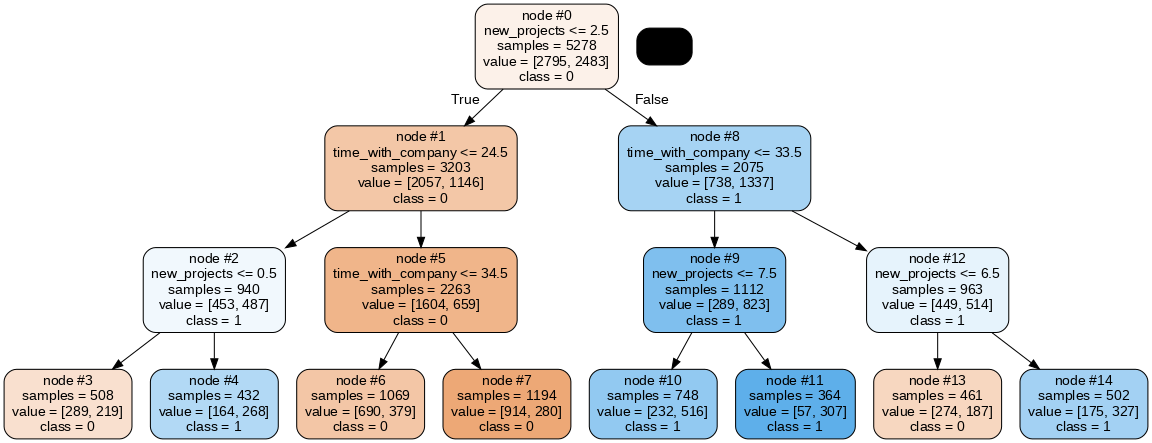

In [6]:
train_set = data
train_copy = train_set.copy()

#@markdown A **Decision Tree** model with depth 3.

# #@markdown Select **which features** to include in the training by ticking the box:
# #@markdown *(You can start with all the features and return later)*
# age = True #@param {type:"boolean"}
# #age_cat = True #@param {type:"boolean"}
# c_charge_degree = True #@param {type:"boolean"}
# race = True #@param {type:"boolean"}
# sex = True #@param {type:"boolean"}
# priors_count = True #@param {type:"boolean"}
time_with_company = True
promotion_received = True
race = True
gender = True
new_projects = True

# mapping between the variables and the names
selection = [time_with_company, promotion_received, race, gender, new_projects]

# all the names of features we could include
all_features = ['time_with_company', 'promotion_received', 'race', 'gender',\
                'new_projects']

target = "left_company"
included_features = []  # list of names for all included features

X_train = None
#X_test = None

#print("Variables included in the model and any transformations done to them:")
for i in range(len(all_features)):
  if( selection[i] ):
      # feature was elected
      col = all_features[i]
      included_features += [col]
      if (train_set[col].dtype==int or train_set[col].dtype==float):
        # numeric variable
        X_train = pd.concat( [X_train, train_set[col]], axis=1 )
      else:
        # categorical variable
        X_train = pd.concat( [X_train, pd.get_dummies(train_set[col], prefix=col)], axis=1 )

# list of names for all included features + target
included_features_with_target = included_features + [target]

# the target variables
y_train = train_set[target]
#y_test = test_set[target]

# have a look at the training data
X_train.head()

# initialize a dictionary to store all the models and their information
all_models = {}

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#@markdown Select or type the **maximum depth** depth your tree is allowed to have:
maximum_depth_of_tree = "3" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}
max_depth_to_train = int(maximum_depth_of_tree)

if max_depth_to_train == "None":
  max_depth_to_train = None
else:
  max_depth_to_train = int(max_depth_to_train)

tree_model = DecisionTreeClassifier(criterion='gini', max_depth=max_depth_to_train, \
                                    random_state=123)
tree_model.fit(X_train, y_train)

# set up a small dictionary with the new model
all_models["tree"] = {}
all_models["tree"]["model"] = tree_model

# #@markdown **Visualization**: select or type the depth you want to see (**`None`** will try printing the full tree):
# max_depth_to_see = "5" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}
max_depth_to_see = max_depth_to_train

if max_depth_to_see == "None":
  max_depth_to_see = None
else:
  max_depth_to_see = int(max_depth_to_see)

dot_data = tree.export_graphviz(tree_model, max_depth=max_depth_to_see, \
                                feature_names=X_train.columns, class_names=["0","1"],
                                label='all', filled=True, impurity=False, node_ids=True, \
                                rounded=True, proportion=False)
#graph = graphviz.Source(dot_data)
#graph

import pydotplus
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"12,12!"')

from IPython.display import Image
Image(pydot_graph.create_png())

To help interpret the tree above, note that each node has several pieces of information:
- A _node ID_ to make it easy to identify the node. E.g., _"node #0"_ is the root.
- A _logical condition_ that compares one of the features with a value. E.g., in node #0, we are comparing the value of `new_projects` with 2.5. The left (respectively, right) subtree has all the data points where that condition is true (respectively, false).
- _samples_ counts how many data points fall in the respective node. E.g., node #0 has 5,278 points.
- _value_ shows two items: the first is the number of data points (in that node) that have a value for `left_company` of 0, and the second value is the number of data points that have `left_company` 1; the sum of these two values always equals _samples_. For instance, node #0 has 2,795 data points that have `left_company` equal to 0 (employees who **did not** leave) and 2,483 data points that have `left_company` equal to 1 (employees who **left**).

Each node is color-coded in shades of **orange** and **blue**. The two colors correspond to the two possible values of `left_company`: **orange** corresponds to 0, and **blue** corresponds to 1, so each node's color tells you the label for the majority of the data points in that node: orange nodes have more zeros, blue nodes have more ones. The **shade** tells you how dominant the label is: the deeper orange (respectively, blue) a node becomes, the larger the fraction of zeros (respectively, ones).

**Predictions** are done by following all the conditions based on the features until a final leaf is reached. With classification problems, it is common to predict the **probability** of the target taking a value of 1, which is done by taking the **average** of the target variable for all the training samples in that leaf node. One can also obtain a prediction of the actual target **label** by taking **a majority vote** in the leaf node (which is the same as comparing the predicted probability with the threshold of 0.5).

### **Evaluate the Decision Tree's predictive performance**
The following code evaluates the model in the overall data, but also separately by **race**, for Caucasians and Minority groups.

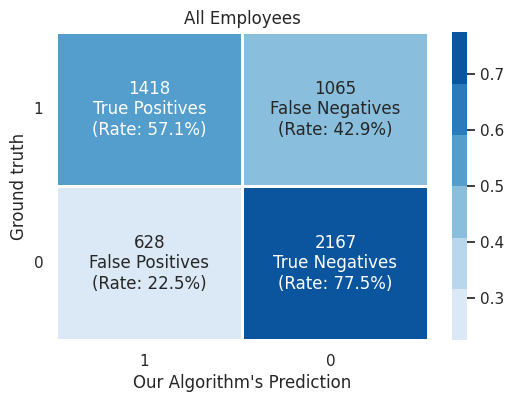

In [7]:
#@markdown **Evaluate the performance through the confusion matrix**

#@markdown Select whether to display performance separately, by **race**.<br>
#@markdown _<font color=red>(WARNING: This uses the protected data feature!)</font>_
display_by_race = False #@param {type:"boolean"}

# **Let's predict in the entire <font color=red>training data</font> and display a few samples**
all_results = predict_all_methods_full_dataset(all_models, X_train, y_train, \
                                              dataset="train", store_df=True)

# join the results for all samples into a single dataframe, including the training data, predictions and errors
all_results["all_samples_and_data_df"] = pd.concat( [ train_copy[included_features_with_target].copy(), \
                                                 all_results["all_samples_df"] ], axis=1)

# #@markdown Select which performance metrics you want to see displayed. If you are not sure what these are, expand the previous section and read the brief description.
# display_all_performance_numbers = True #@param {type:"boolean"}
# display_confusion_matrix = True #@param {type:"boolean"}
# display_ROC_and_precision_recall_curves = False #@param {type:"boolean"}
display_all_performance_numbers = False
display_confusion_matrix = True
display_ROC_and_precision_recall_curves = False

# # @markdown <br>**You can further customize some aspects of the plot**
# # @markdown - **`fig_width`** : the width of each figure in inches (leave as **Auto** if unsure)
# # @markdown - **`fig_height`** : the height of each figure in inches (leave as **Auto** if unsure)
# fig_width = 'Auto' #@param ['Auto']{allow-input : true}
# fig_height = 'Auto' #@param ['Auto']{allow-input : true}
fig_width = 'Auto'
fig_height = 'Auto'

if fig_width=='Auto':
  fig_width=8.0
else:
  fig_width=np.float(fig_width)

if fig_height=='Auto':
  fig_height=6.0
else:
  fig_height=np.float(fig_height)

all_model_names = list(all_models.keys())
num_models = len(all_model_names)

# **Determine whether the predictive performance depends on the features**
model_name = "tree"
feature = "race"
num_bins = 3

# if the dictionary to store results by feature for that model does not exist, create it
if "by_feature" not in all_results[model_name].keys():
  all_results[model_name]["by_feature"] = {}

evaluate_performance_with_feature_values(model_name=model_name, \
                                         model=all_models[model_name]["model"],\
                                         feature=feature, X_data=X_train, \
                                         y_data=y_train,
                                         full_data_training=train_set, \
                                         results_full_data=all_results[model_name],\
                                         num_bins=num_bins, \
                                         prefix_title="", class_names=None,\
                                         include_full_dataset_eval=True,\
                                         include_separate_feature_eval=display_by_race,\
                                         display_conf_mat=display_confusion_matrix,\
                                         display_roc_pr=display_ROC_and_precision_recall_curves, \
                                         plot_together=False,\
                                         ax_roc=None, ax_pr=None,
                                         figsize=(6,4),\
                                         pref_xlabel="Our Algorithm's Prediction")

<font color=black>To correctly interpret a confusion matrix, it is useful to think of the specific example of running a COVID test to detect if someone is actually infected. In this case, the **prediction** corresponds to the result of the test, and the **ground truth** corresponds to whether or not the person is infected with the virus. The following terminology is salient:</font><br>
> - use **true** when the prediction is correct (i.e., it matches the ground truth) and **false** when the prediction is wrong;
> - use **positive** when the prediction is $1$ (_e.g., the test result comes back "positive"_) and **negative** when the prediction is $0$ (_e.g., the test result comes back "negative"_).

This gives rise to the following four cases and associated terminology:
> * <font color=green>**True Positive (TP)**</font>: the test result is positive (i.e., model predicts $1$) and that matches the truth.
> * <font color=green>**True Negative (TN)**</font>: the test result is negative (i.e., model predicts $0$) and that matches the truth.
> * <font color=red>**False Positive (FP)**</font>: the test result is positive (i.e., model predicts $1$), but the ground truth is negative ($0$).
> * <font color=red>**False Negative (FN)**</font>: the test result is negative (i.e., model predicts $0$), but the ground truth is positive ($1$).

It is common to list these four values in a 2x2 matrix called a **confusion matrix**, which is a concise way to summarize the performance of a binary classifier. These tables can be used as a starting point to calculate other performance metrics, as follows:
- **True Positive Rate (TPR)** (also known as [**sensitivity**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)): the fraction of positive labels correctly identified as positive **TP/(TP+FN)**
- **True Negative Rate (TNR)** (also known as [**specificity**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)): the fraction of negative labels correctly identified as negative, **TN/(TN+FP)**
- **False Positive Rate (FPR)**: the fraction of negative labels incorrectly identified as positive, **FP/(FP+TN) = 1 - TNR**
- **False Negative Rate (FNR)**: the fraction of positive labels incorrectly identified as negative, **FN/(FN+TP) = 1 - TPR**

# **3. Evaluating and Using RETAIN: A Proprietary / "Black-Box" Model**
Suppose that your company is using a risk scoring tool called **RETAIN**, which is a proprietary software designed by a third-party provider. The tool can produce, for every employee, **a risk score from 1 to 10** (with higher values indicating higher risk) and a **risk label** based on the score: those with risk score of 5 or above are labeled as **1** (high risk), and those with scores of 4 or below are labeled as **0** (low risk).

The software provider assures you that **RETAIN was created without any protected features like gender or race**. You cannot understand how RETAIN reaches its predictions, but you can use it to construct risk scores for all the employees in your data and  evaluate the relationship between RETAIN's predictions and the ground truth (i.e., what happened with your employees in reality). The next code allows you to do exactly that. Using the subsequent outputs, please address the following questions:
<font color=blue><br><br>
**Q3. Suppose you used the RETAIN algorithm to make decisions and you completely ignored the <font color=red>gender</font> feature. Would your decisions be gender biased? If so, against which gender?** _(please answer in poll)_<br><br>
**Q4. Suppose you used the RETAIN algorithm to make decisions and you completely ignored the <font color=red>race</font> feature. Would your decisions be racially biased? If so, against which race?** _(please answer in poll)_<br><br>
**Q5. If there is bias, how could you fix it?** _(brainstorming)_
</font>

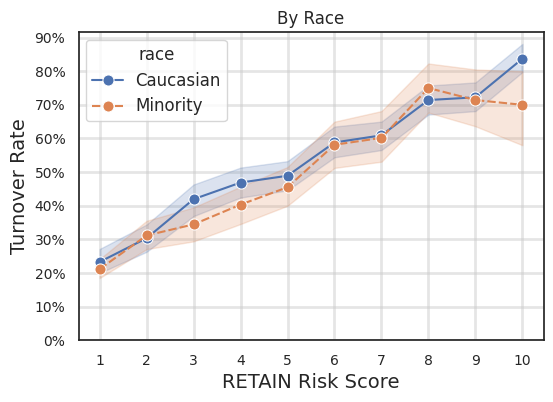

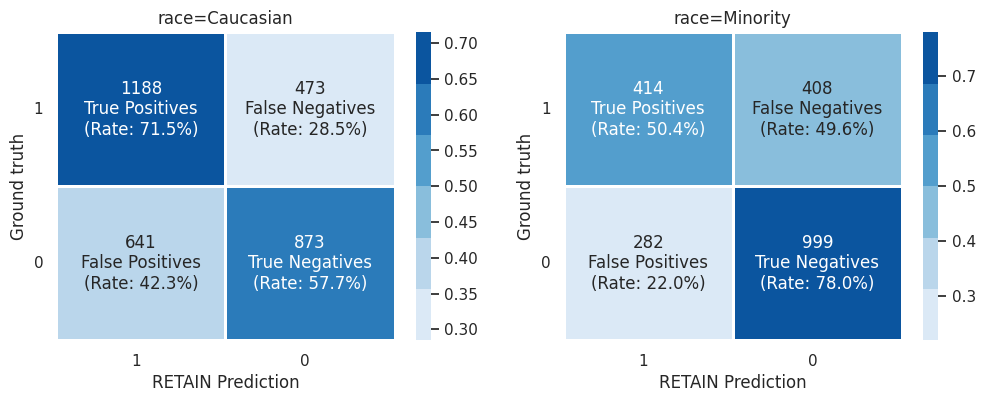

In [8]:
#@markdown **Evaluate RETAIN's performance on your data**

#@markdown Select whether to evaluate separately by <font color=blue>**gender**</font> or <font color=blue>**race**</font>.<br>
#@markdown <font color=red>_(WARNING: This would involve using a protected data feature!)_</font>
evaluate_separately = "Separately by race" #@param["No (Use entire dataset)", "Separately by gender", "Separately by race"] {allow-input: false}

if evaluate_separately == "Separately by gender":
   separate_by_feature = True
   feature = "gender"
   legend_text = ["Male","Female"]

elif evaluate_separately == "Separately by race":
   separate_by_feature = True
   feature = "race"
   legend_text = ["Caucasian","Minority"]

else:
   separate_by_feature = False

### BASIC SETTINGS FOR THE GRAPH
fig_width = 6.0
fig_height = 4.0
font_size = 14
legend_font_size = 12
tick_size = 10
palette_choice = 'tab10'
palette = sns.color_palette(palette_choice)

# get the full data, including the COMPAS score
data2 = orig_full_data

# define a new column with a risk label: LOW for score <=4, otherwise HIGH
data2["risk_label"] = np.where(data2["decile_score"] <= 4, "LOW", "MED/HIGH")
data2["y_hat"] = np.where(data2["decile_score"] <= 4, 0, 1)
unique_scores = np.sort(data2["decile_score"].unique())

#sns.set_theme(style="darkgrid")
sns.set_theme(style="white")

# adjust size accordingly
if separate_by_feature:
    # we plot on two rows: first row attrition rates, second conf. matrix
    # we only set up the former here, and let the conf matrix do its separate plot
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax1 = plt.gca()
    ax2 = None  # this means that it will generate its own figure...
else:
    # plot the attrition rates and confusion matrix on a single row
    fig = plt.figure(figsize=(2*fig_width, fig_height))
    plt.subplot(1,2,2)
    ax2 = plt.gca()

    plt.subplot(1,2,1)
    ax1 = plt.gca()

### ATTRITION RATE PLOTS (with risk score)
ax1.grid(alpha=.5, linewidth=2)
if separate_by_feature:
    # separate plots
    lnp = sns.lineplot(x="decile_score", y="left_company", hue=feature, \
                  style=feature, marker="o", markersize=8,
                  errorbar=('ci',90), err_style='band', data=data2,
                  legend = legend_text, axes=ax1)
    plt.title(f"By {feature.capitalize()}")
    plt.setp(lnp.get_legend().get_texts(), fontsize=legend_font_size)

else:
    # plot for all employees
    lnp = sns.lineplot(x="decile_score", y="left_company", marker="*", markersize=10,
                      errorbar=('ci',90), err_style='band', data=data2, axes=ax1)
    plt.title("All employees")
    plt.ylabel("Attrition Rate", fontsize=font_size)

plt.xticks(unique_scores)
plt.yticks(np.arange(0,1,0.1),[ str(x)+"%" for x in np.arange(0,100,10)])
plt.tick_params(axis='x',labelsize=tick_size)
plt.tick_params(axis='y',labelsize=tick_size)
plt.xlabel("RETAIN Risk Score", fontsize=font_size)
plt.ylabel("Turnover Rate", fontsize=font_size)
plt.xticks

### CALCULATE CONFUSION MATRICES
# create a dictionary with the right structure so we can use the same function to plot confusion matrices
results_hack = {}
results_hack["y_hat"] = np.array(data2["y_hat"])
results_hack["y_prob"] = np.array(data2["decile_score"]/10)
results_hack["pos_label_idx"] = 1
results_hack["summary"] = {}
#results_hack["summary_df"] = pd.DataFrame()

# plot the desired combination of confusion matrices
evaluate_performance_with_feature_values(model_name="RETAIN Algo", \
                                         model="",\
                                         feature=feature, X_data=data2, \
                                         y_data=data2["left_company"],
                                         full_data_training=data2, \
                                         results_full_data=results_hack,\
                                         num_bins=3, \
                                         prefix_title="", class_names=None,\
                                         include_full_dataset_eval=(not(separate_by_feature)),\
                                         include_separate_feature_eval=separate_by_feature,\
                                         display_conf_mat=True,\
                                         display_roc_pr=False, \
                                         plot_together=False,\
                                         ax_confmat=ax2,\
                                         ax_roc=None, ax_pr=None,
                                         figsize=(6,4),
                                         pref_xlabel="RETAIN Prediction")
plt.show()

**A clarification about the two figures.**
 - The <font color=black>**left (or top) figure**</font> shows the **true turnover rate** as a function of **RETAIN's risk score**. The center line indicates the turnover rate for all employees with the given score, and the band is a confidence interval.
 - The <font color=black>**right (or bottom) figure**</font> shows **confusion matrices** obtained based on **RETAIN's risk label**.